In [1]:
# General
import sys
import os
from time import time
from collections import OrderedDict as od
from importlib import reload
from glob import glob
import itertools
import h5py

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
import scipy.io as sio

# Stats
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random
from sklearn.decomposition import PCA

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15 
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 17
mpl.rcParams['axes.labelpad'] = 10
mpl.rcParams['axes.titlesize'] = 19
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 19
mpl.rcParams['figure.figsize'] = (6.85039, 4.79527) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42

# Personal
sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects/manning_replication')
sys.path.append('/home1/dscho/code/projects')
import data_io as dio
import array_operations as aop
from eeg_plotting import plot_trace, plot_trace2
from time_cells import spike_sorting, spike_preproc, events_preproc, goldmine_behavior

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   'w',
                                   colors[1]), 501)

font = {'tick': 12,
        'label': 14,
        'annot': 12,
        'fig': 16}

## Perform alignment

In [93]:
subj_sess = 'U532_ses0'

# Read events file and get event synctimes.
events, event_synctimes = events_preproc.read_events_json(subj_sess)

# Load LFP timestamps.
lfp_timestamps, sr = spike_sorting.load_lfp_timestamps(subj_sess)

# Load the sync channel.
sync_chan = events_preproc.load_syncs(subj_sess, data_key='data')

# Identify sync pulses in the sync channel EEG.
pulse_startinds = events_preproc.find_pulse_starts(sync_chan, 
                                                   sampling_rate=sr, 
                                                   pulse_thresh=200, 
                                                   intrapulse_thresh_ms=20, 
                                                   interpulse_thresh_ms=790)
lfp_synctimes = lfp_timestamps[pulse_startinds]
print('Detected {} syncs for {} sync pulse events'.format(len(pulse_startinds), len(events.loc[events.key=='syncPulse', 'time'])))

# Find matching sync pulse pairs.
event_synctimes_adj, lfp_synctimes_adj = events_preproc.pair_sync_pulses(event_synctimes, 
                                                                         lfp_synctimes)

# Perform the alignment.
alignment = events_preproc.align_sync_pulses(event_synctimes_adj, 
                                             lfp_synctimes_adj)

# Apply the alignment to all event times.
events['time'] = events['time'].apply(lambda x: alignment['sync_params']['intercept'] + (alignment['sync_params']['slope'] * x))

# How did our alignment go?
print('{} event sync pulses'.format(len(event_synctimes_adj)))
print('{} LFP sync pulses identified'.format(len(lfp_synctimes_adj)))
print('\n--------------------\nAlignment parameters\n--------------------')
for k, v in alignment.items():
    print('{}: {}'.format(k, v))

82883 events recorded over 72 min and 40 sec
Conversion factor is 1
128221050 timestamps over 71 min and 14.0 s
Sampling rate is 30000 Hz
Detected 4237 EEG sync pulses
Detected 4237 syncs for 4367 sync pulse events
Retained 4125 sync pulses
4125 event sync pulses
4125 LFP sync pulses identified

--------------------
Alignment parameters
--------------------
sync_params: OrderedDict([('intercept', -98693.58337329054), ('slope', 1.0000164988317595)])
before_stats: OrderedDict([('ipi_r', 0.9999998057687918), ('ipi_diff', 0.17866216857730868), ('rmse', 98656.92164624835), ('err_pcts', 0      98621.343392
1      98622.310572
5      98625.050749
10     98628.673431
25     98639.310010
50     98657.370215
75     98674.843392
90     98684.453382
95     98687.358874
99     98689.521910
100    98690.186882
dtype: float64)])
after_stats: OrderedDict([('ipi_r', 0.9999998057687919), ('ipi_diff', 0.1780932469303897), ('rmse', 0.4863647842935605), ('err_pcts', 0      0.000126
1      0.005992
5      0

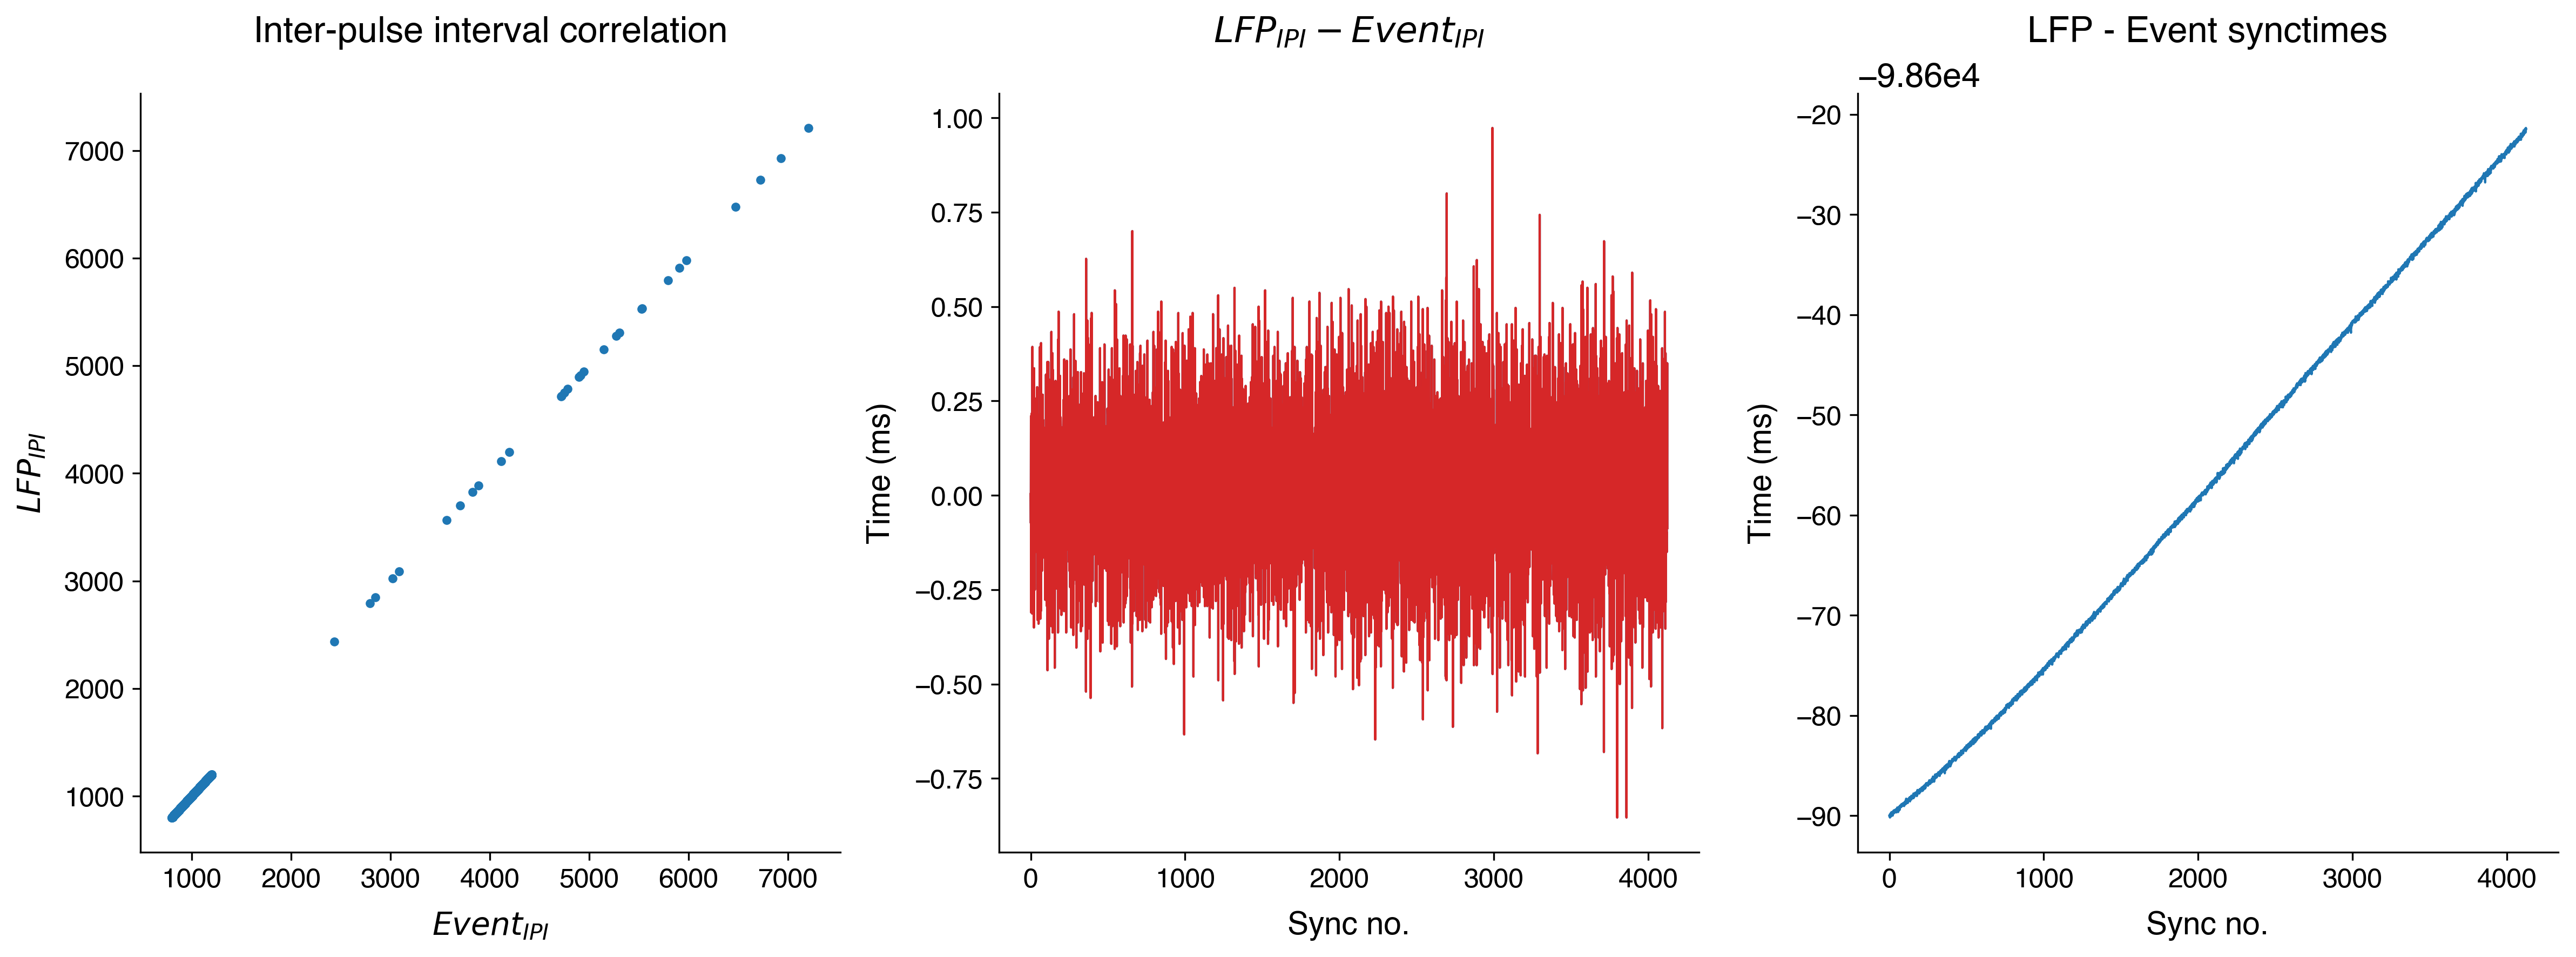

In [94]:
fig, ax = plt.subplots(1, 3, figsize=(16, 6), dpi=300)
ax = np.ravel(ax)

min_syncs = np.min((len(event_synctimes_adj), len(lfp_synctimes_adj)))
start = 0
stop = None

i = 0
ax[i].scatter(np.diff(event_synctimes_adj), np.diff(lfp_synctimes_adj))
ax[i].set_xlabel('$Event_{IPI}$', fontsize=font['label'], labelpad=8)
ax[i].set_ylabel('$LFP_{IPI}$', fontsize=font['label'], labelpad=8)
ax[i].set_title('Inter-pulse interval correlation', fontsize=font['fig'], y=1.05)

i = 1
ax[i].plot(np.diff(lfp_synctimes_adj)[start:stop] - np.diff(event_synctimes_adj)[start:stop])
ax[i].plot(np.diff(lfp_synctimes_adj)[start:stop] - np.diff(event_synctimes_adj)[start:stop])
ax[i].set_xlabel('Sync no.', fontsize=font['label'], labelpad=8)
ax[i].set_ylabel('Time (ms)', fontsize=font['label'], labelpad=8)
ax[i].set_title('$LFP_{IPI} - Event_{IPI}$', fontsize=font['fig'], y=1.05)

i = 2
ax[i].plot(lfp_synctimes_adj[start:stop] - event_synctimes_adj[start:stop])
ax[i].set_xlabel('Sync no.', fontsize=font['label'], labelpad=8)
ax[i].set_ylabel('Time (ms)', fontsize=font['label'], labelpad=8)
ax[i].set_title('LFP - Event synctimes', fontsize=font['fig'], y=1.05)

for i in range(len(ax)):
    ax[i].tick_params(axis='both', which='major', labelsize=font['tick'])
fig.tight_layout()

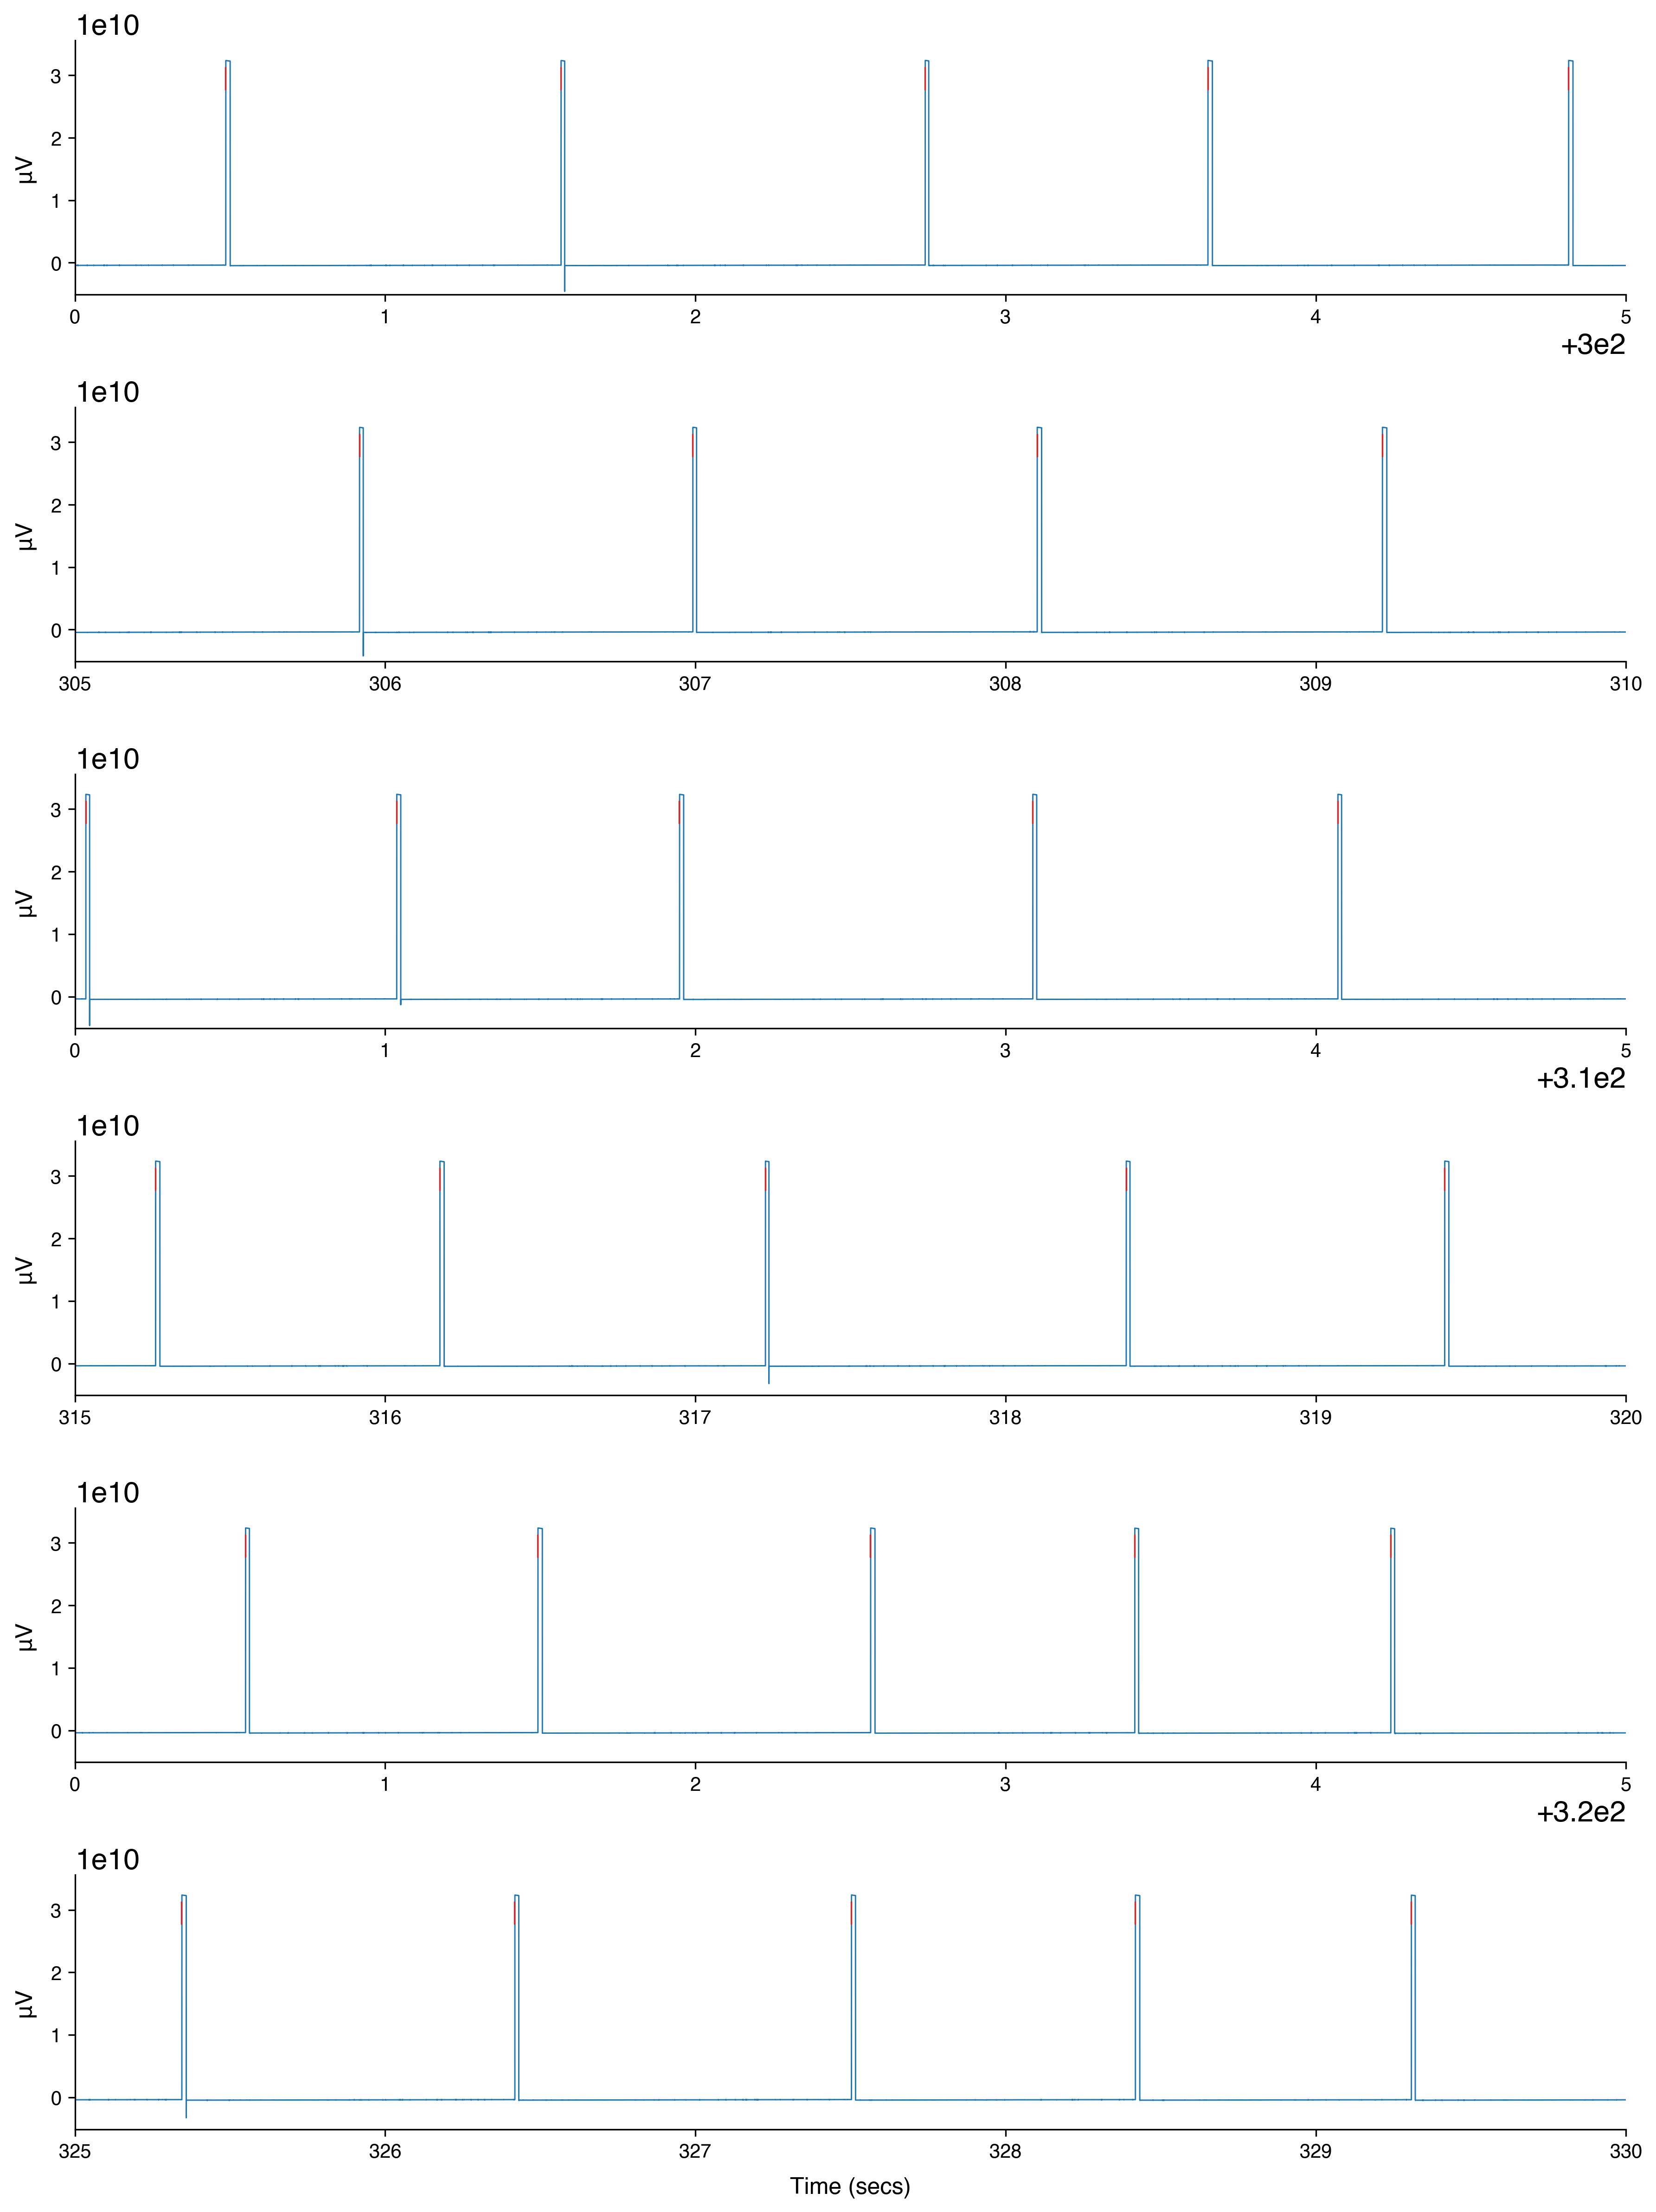

In [95]:
event_synctimes = events.loc[events['key']=='syncPulse', 'time'].values
event_pulse_inds = (np.array([x for x in (event_synctimes-lfp_timestamps[0]) * (sr/1e3) 
                              if x<len(lfp_timestamps)])).astype(np.int64)
event_pulse_startinds_train = np.zeros(len(sync_chan))
event_pulse_startinds_train[event_pulse_inds] = 1

fig, ax = plot_trace2(sync_chan, spike_dat=event_pulse_startinds_train,
                      start=300, duration=30, nwin=6, x_units='secs', sampling_rate=sr)

## Format events and spikes

In [211]:
proc_events = False
proc_spikes = True
n_perms = 1000
verbose = True

start_time = time()

print(subj_sess)
if proc_events:
    # Load events and event times.
    events = events_preproc.format_events(events=events,
                                          noisy_trials=[],
                                          remove_incomplete_trials=True,
                                          remove_noisy_trials=False,
                                          remove_paused_trials=False,
                                          overwrite=True,
                                          save_output=True,
                                          verbose=verbose)

    # Save event time indices.
    events = goldmine_behavior.Events(subj_sess)
    _d = events.save_time_indices(overwrite=False)
    
if proc_spikes:
    # Load spikes.
    spikes = spike_preproc.format_spikes(subj_sess,
                                         conv_factor='infer',
                                         fr_thresh=0.1,
                                         overwrite=True,
                                         save_output=True,
                                         split_files=True,
                                         verbose=verbose)

#     # Add spike time null distribution for each trial and trial phase.
#     spikes = spike_preproc.add_null_to_spikes(subj_sess,
#                                               events.event_times,
#                                               spikes=spikes,
#                                               output_col='spike_times_null_trial_phase',
#                                               n_perms=n_perms,
#                                               save_output=True,
#                                               split_files=True,
#                                               verbose=verbose)

print('Done in {:.2f} s'.format(time() - start_time))

U532_ses0
Conversion factor is 1
128221050 timestamps over 71 min and 14.0 s
Sampling rate is 30000 Hz
Found 56 wave_clus files.

Found 65 neurons
Firing rates:
count    65.000000
mean      2.759410
std       2.377865
min       0.160270
25%       0.663308
50%       1.666341
75%       4.351626
max       8.075507
Name: fr, dtype: float64

        unit  chan        fr
hemroi                      
LA        15     7  1.598256
LFSG       1     1  4.351626
LOF        1     1  3.656732
RA        10     7  1.366273
RAH       24     7  1.370953
RFSG      14     8  3.706217
Saved /home1/dscho/projects/time_cells/analysis/spikes/U532_ses0-CSC2-unit1-spikes.pkl
Saved /home1/dscho/projects/time_cells/analysis/spikes/U532_ses0-CSC2-unit2-spikes.pkl
Saved /home1/dscho/projects/time_cells/analysis/spikes/U532_ses0-CSC2-unit3-spikes.pkl
Saved /home1/dscho/projects/time_cells/analysis/spikes/U532_ses0-CSC3-unit1-spikes.pkl
Saved /home1/dscho/projects/time_cells/analysis/spikes/U532_ses0-CSC3-unit2-spike

In [212]:
print(subj_sess)
events = goldmine_behavior.Events(subj_sess)

U532_ses0
